In [1]:
!pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to c:\users\астемир\appdata\local\temp\pip-req-build-yp1ngwbu
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git 'C:\Users\Астемир\AppData\Local\Temp\pip-req-build-yp1ngwbu'


In [2]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st


from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [3]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [4]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10 (2).csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

df_IR['DGS10'] = np.float64(df_IR.DGS10)
df_IR['DATE'] = pd.to_datetime(df_IR.DATE)

In [5]:
df_IR

,DATE,DGS10
0,1962-12-31,3.85
2,1963-01-02,3.82
3,1963-01-03,3.81
4,1963-01-04,3.84
5,1963-01-07,3.83
...,...,...
16130,2024-10-28,4.28
16131,2024-10-29,4.28
16132,2024-10-30,4.29
16133,2024-10-31,4.28


Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

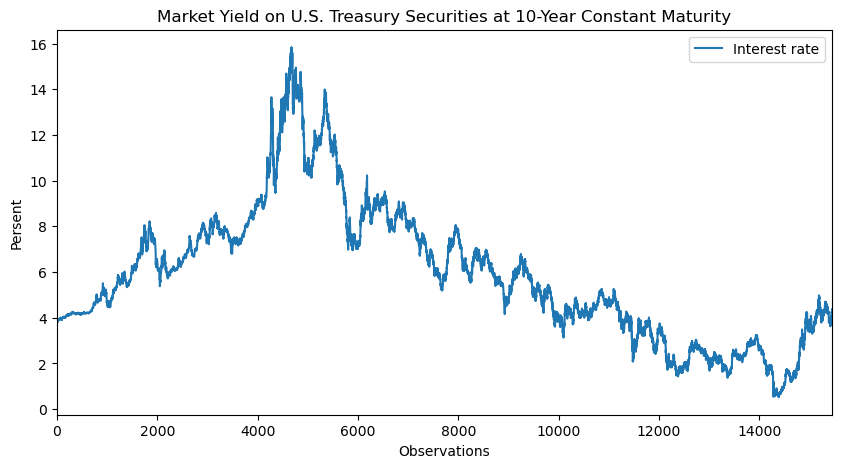

In [6]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

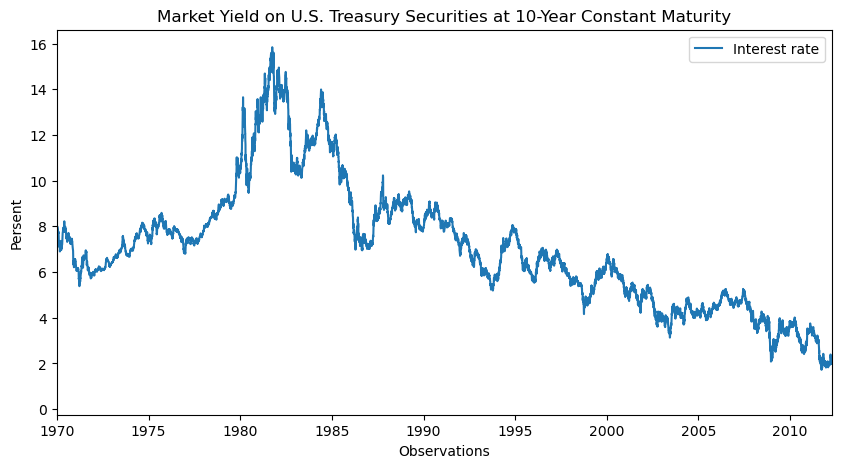

In [7]:
# Plot
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_IR.DATE, df_IR.DGS10, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(df_IR.DGS10))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [8]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [9]:


model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]



param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]






In [10]:
def get_results( model_name, est, params):
    best_ind = argmin(est)
    print("AIC values for Shoji-Ozaki estimation:\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        {:.3f} - {} model with params {},\n \
        ".format(
        est[0], model_name[0], params[0],\
        est[1], model_name[1], params[1],\
        est[2], model_name[2], params[2],\
        est[3], model_name[3], params[3],\
        est[4], model_name[4], params[4],\
        est[5], model_name[5], params[5],\
        est[6], model_name[6], params[6]))

    print("The best model is {} \
        with param {}".format(model_name[best_ind], params[best_ind]))
    return best_ind
    





In [11]:
# a) fit using Kessler method:
# Set parameters for estimators:

def kessler(sample, param_bounds, param_guess):
    dt = 1. / 252
    kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    return kessler_est, kessler_params


def shoji_Ozaki(sample, param_bounds, param_guess):
    dt = 1. / 252
    K = 1

    shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    return shoji_ozaki_est, shoji_ozaki_params



def euler(sample, param_bounds, param_guess):
# Estimate max likelyhood, using Shoji-Ozaki
    dt = 1. / 252
    K = 1
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                for i in range (len(param_bounds))]
    eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                for i in range (len(param_bounds))]
    
    return euler_est, eu_params

In [12]:
kessler_est, kessler_params = kessler(sample=sample, param_bounds=param_bounds, param_guess=param_guess)

Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628914473
`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 132, CG iterations: 58, optimality: 1.33e-02, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [0.02687632 1.04212282]
Final Likelihood: 20150.858766309157
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899940.3713308276


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 82, function evaluations: 460, CG iterations: 284, optimality: 3.86e+01, constraint violation: 0.00e+00, execution time:  1.6 s.
Final Params: [0.04973794 0.12308258 0.58965203 0.32086411]
Final Likelihood: 20924.008616524894
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3255.629154285149
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 156, CG iterations: 36, optimality: 1.41e+01, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.01007676 0.01004482 0.44607708]
Final Likelihood: 20641.106517828463
Initial Params: [0.01, 0.2]
Initial Likelihood: 16442.84017788993
`xtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 102, CG iterations: 37, optimality: 1.76e+01, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [0.04306224 0.24453044]
Final Likelihood: 17066.09769517315
Initial Params: [0.01, 0.

In [13]:
shoji_ozaki_est, shoji_ozaki_params =  shoji_Ozaki(sample, param_bounds, param_guess)


Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628847162
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 90, CG iterations: 54, optimality: 7.93e-07, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [0.01055339 1.04212238]
Final Likelihood: 20150.868192785943
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899945.3048192728
`xtol` termination condition is satisfied.
Number of iterations: 155, function evaluations: 765, CG iterations: 497, optimality: 8.93e-03, constraint violation: 0.00e+00, execution time:  1.3 s.
Final Params: [0.0113267  0.22271155 0.59021228 0.31912468]
Final Likelihood: 20926.00471429682
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3246.9473165988798
`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 248, CG iterations: 148, optimality: 2.38e-01, constraint violation: 0.00e+00, execution time: 0.34 s.
Final Params: [0.0250517  2.

In [14]:
euler_est, eu_params = euler(sample, param_bounds, param_guess)

Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628847162
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 90, CG iterations: 54, optimality: 7.93e-07, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.01055025 1.04212239]
Final Likelihood: 20150.868193153015
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3248.0865903621607
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 332, CG iterations: 193, optimality: 2.87e-05, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.06935714 5.93

In [15]:
best_ind_kessler = get_results(model_name, kessler_est, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -40297.718 - BrownianMotion model with params [0.02687632 1.04212282],
         -41840.017 - CEV model with params [0.04973794 0.12308258 0.58965203 0.32086411],
         -41276.213 - CIR model with params [0.01007676 0.01004482 0.44607708],
         -34128.195 - GeometricBM model with params [0.04306224 0.24453044],
         -34162.881 - IGBM model with params [0.2021986  4.87155722 0.24426688],
         -40296.110 - OrnsteinUhlenbeck model with params [0.01456313 0.40884138 1.04211052],
         -41843.170 - CKLS model with params [0.10124157 0.01391757 0.59080348 0.31814813],
         
The best model is CKLS         with param [0.10124157 0.01391757 0.59080348 0.31814813]


In [16]:
best_ind_shoji = get_results(model_name,shoji_ozaki_est, shoji_ozaki_params )

AIC values for Shoji-Ozaki estimation:
         -40297.736 - BrownianMotion model with params [0.01055339 1.04212238],
         -41844.009 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -41276.260 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -34137.874 - GeometricBM model with params [0.0341869  0.24484606],
         -34156.485 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         -40296.113 - OrnsteinUhlenbeck model with params [0.01274842 0.40623348 1.04213606],
         -41843.751 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is CEV         with param [0.0113267  0.22271155 0.59021228 0.31912468]


In [17]:
best_ind_euler = get_results(model_name, euler_est, eu_params)

AIC values for Shoji-Ozaki estimation:
         -40297.736 - BrownianMotion model with params [0.01055025 1.04212239],
         -41847.042 - CEV model with params [0.06865678 6.061304   0.5898921  0.3193843 ],
         -41279.321 - CIR model with params [0.06935714 5.93322133 0.44602436],
         -34137.874 - GeometricBM model with params [0.03388114 0.24486267],
         -34156.485 - IGBM model with params [0.14234825 5.17145521 0.24469931],
         -40297.723 - OrnsteinUhlenbeck model with params [0.06307075 6.01321481 1.04205537],
         -41843.753 - CKLS model with params [0.03825314 0.01000077 0.59008064 0.31925311],
         
The best model is CEV         with param [0.06865678 6.061304   0.5898921  0.3193843 ]


In [18]:
list_best_ind = [best_ind_kessler,  best_ind_shoji, best_ind_euler,]

model_name_best_ind = [model_name[x] for x in list_best_ind]

print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name_best_ind,\
    kessler_params[best_ind_kessler],\
    shoji_ozaki_params[best_ind_shoji],\
    eu_params[best_ind_euler]))

For the best model ['CKLS', 'CEV', 'CEV']
     params are:
     [0.10124157 0.01391757 0.59080348 0.31814813],
     [0.0113267  0.22271155 0.59021228 0.31912468],
     [0.06865678 6.061304   0.5898921  0.3193843 ]


In [19]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

* Обернём всё в один класс ModelEstimator

In [20]:

class ModelEstimator:
    def __init__(self, sample, model_name=None, models=None, param_bounds=None, param_guess=None):
        """
        sample: array-like, набор данных
        model_name: str or list, название модели (или список названий моделей)
        models: объект модели или список моделей
        param_bounds: список границ параметров для каждой модели (или границы для одной модели)
        param_guess: список начальных значений параметров для каждой модели (или начальные значения для одной модели)
        """
        self.sample = sample

        # Если переданы отдельная модель и ее название, конвертируем их в списки
        if isinstance(model_name, str) and models is not None:
            self.model_name = [model_name]
            self.models = [models]
        else:
            self.model_name = model_name if model_name is not None else []
            self.models = models if models is not None else []
        
        # Если заданы параметры, используем их; иначе - оставляем None и подбираем позже
        self.param_bounds = param_bounds if param_bounds is not None else []
        self.param_guess = param_guess if param_guess is not None else []
        
        # Если не заданы границы и предположения, используем стандартные значения для моделей
        self.default_bounds = {
            "BrownianMotion": [(0.01, 10), (0.01, 2)],
            "CEV": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)],
            "CIR": [(0.01, 10), (0.01, 10), (0.01, 2)],
            "GeometricBM": [(0.01, 10), (0.01, 2)],
            "IGBM": [(0.01, 10), (0.01, 10), (0.01, 2)],
            "OrnsteinUhlenbeck": [(0.01, 10), (0.01, 10), (0.01, 2)],
            "CKLS": [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]
        }
        
        self.default_guesses = {
            "BrownianMotion": [0.01, 0.2],
            "CEV": [0.01, 0.01, 0.01, 0.2],
            "CIR": [0.01, 0.01, 0.2],
            "GeometricBM": [0.01, 0.2],
            "IGBM": [0.01, 0.01, 0.2],
            "OrnsteinUhlenbeck": [0.01, 0.01, 0.2],
            "CKLS": [0.01, 0.01, 0.01, 0.2]
        }
        
        # Заполняем границы и начальные значения параметров, если они не указаны
        if not self.param_bounds:
            self.param_bounds = [self.default_bounds[name] for name in self.model_name]
        
        if not self.param_guess:
            self.param_guess = [self.default_guesses[name] for name in self.model_name]
        
        self.estimates = None
        self.params = None

    def fit_kessler(self):
        dt = 1. / 252
        self.estimates = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=KesslerDensity(self.models[i])).estimate_params(self.param_guess[i]).aic
            for i in range(len(self.models))
        ]
        self.params = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=KesslerDensity(self.models[i])).estimate_params(self.param_guess[i]).params
            for i in range(len(self.models))
        ]
        return self.estimates, self.params

    def fit_shoji_ozaki(self):
        dt = 1. / 252
        self.estimates = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=ShojiOzakiDensity(self.models[i])).estimate_params(self.param_guess[i]).aic
            for i in range(len(self.models))
        ]
        self.params = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=ShojiOzakiDensity(self.models[i])).estimate_params(self.param_guess[i]).params
            for i in range(len(self.models))
        ]
        return self.estimates, self.params

    def fit_euler(self):
        dt = 1. / 252
        self.estimates = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=EulerDensity(self.models[i])).estimate_params(self.param_guess[i]).aic
            for i in range(len(self.models))
        ]
        self.params = [
            AnalyticalMLE(self.sample, self.param_bounds[i], dt, density=EulerDensity(self.models[i])).estimate_params(self.param_guess[i]).params
            for i in range(len(self.models))
        ]
        return self.estimates, self.params

    def get_result(self):
        if self.estimates is None or self.params is None:
            print("Сначала выполните метод подбора (fit_kessler, fit_shoji_ozaki или fit_euler).")
            return None
        best_ind = argmin(self.estimates)

        if len(self.model_name) > 1:
           
            print("AIC values:")
            for i in range(len(self.model_name)):
                print(f"{self.estimates[i]:.3f} - {self.model_name[i]} model with params {self.params[i]}")
            print(f"The best model is {self.model_name[best_ind]} with param {self.params[best_ind]}")
        else:
            
            print(f"AIC value: {self.estimates[0]:.3f} - {self.model_name[0]} model with params {self.params[0]}")
        
        return best_ind


In [21]:
euler, shoji_Ozaki, kessler = ( ModelEstimator(sample, model_name, model, param_bounds, param_guess), 
                                ModelEstimator(sample, model_name, model, param_bounds, param_guess),
                                ModelEstimator(sample, model_name, model, param_bounds, param_guess)
                               )


In [22]:
euler.fit_euler()
euler.get_result()

shoji_Ozaki.fit_shoji_ozaki()
shoji_Ozaki.get_result()

kessler.fit_kessler()
kessler.get_result()

Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628847162
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 90, CG iterations: 54, optimality: 7.93e-07, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.01055025 1.04212239]
Final Likelihood: 20150.868193153015
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3248.0865903621607
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 332, CG iterations: 193, optimality: 2.87e-05, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.06935714 5.93

6

In [23]:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

processes = {'CEV': CEV_pr}

In [24]:
sample = df_IR.DGS10.values

In [25]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

In [26]:
euler_CEV, shoji_Ozaki_CEV, kessler_CEV = (ModelEstimator(sample, model_name='CEV', models=CEV()),
                                              ModelEstimator(sample, model_name='CEV', models=CEV()),
                                              ModelEstimator(sample, model_name='CEV', models=CEV())
)
params_euler = euler_CEV.fit_euler()
params_shoji = shoji_Ozaki_CEV.fit_shoji_ozaki()
params_kessler_CKLS = kessler_CEV.fit_kessler()


Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.56 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899945.3048192728
`xtol` termination condition is satisfied.
Number of iterations: 155, function evaluations: 765, CG iterations: 497, optimality: 8.93e-03, constraint violation: 0.00e+00, execution time

In [27]:
MODEL ="CEV"

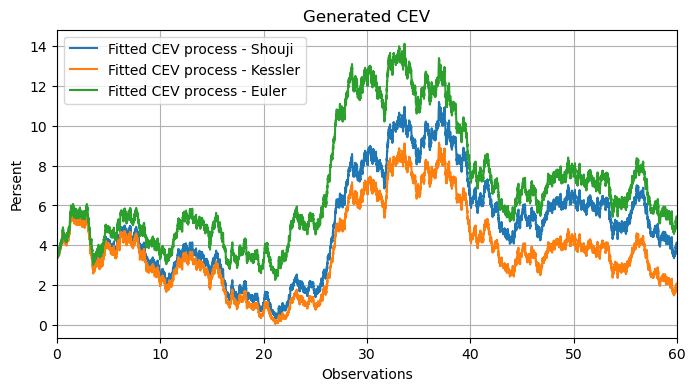

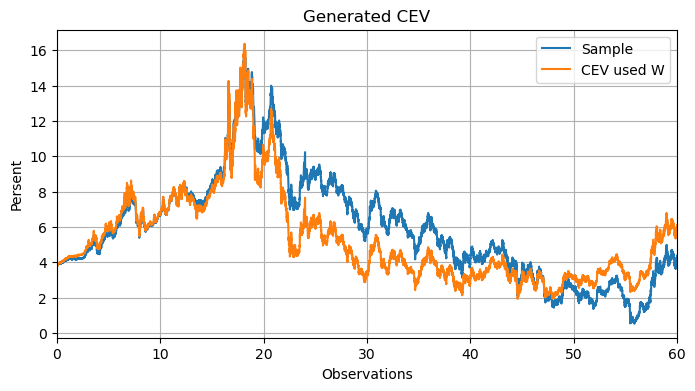

In [28]:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + processes[MODEL](cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + processes[MODEL](cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + processes[MODEL](cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + processes[MODEL](ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [29]:
euler_CKLS, shoji_Ozaki_CKLS, kessler_CKLS = (ModelEstimator(sample, model_name='CKLS', models=CKLS()),
                                              ModelEstimator(sample, model_name='CKLS', models=CKLS()),
                                              ModelEstimator(sample, model_name='CKLS', models=CKLS())
)
params_euler = (euler_CKLS.fit_euler())[1]
params_shoji = (shoji_Ozaki_CKLS.fit_shoji_ozaki())[1]
params_kessler_CKLS = (kessler_CKLS.fit_kessler())[1]


MODEL = "CKLS"


Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899792.4608418238
`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 370, CG iterations: 186, optimality: 1.71e-04, constraint violation: 0.00e+00, execution time: 0.44 s.
Final Params: [0.03825314 0.01000077 0.59008064 0.31925311]
Final Likelihood: 20925.876367201276
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899792.4608418238
`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 370, CG iterations: 186, optimality: 1.71e-04, constraint violation: 0.00e+00, execution time: 0.49 s.
Final Params: [0.03825314 0.01000077 0.59008064 0.31925311]
Final Likelihood: 20925.876367201276
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899787.2325089856
`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 415, CG iterations: 207, optimality: 1.78e-03, constraint violation: 0.00e+00, execution t

In [30]:
params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_CKLS_p = params_kessler_CKLS[0].tolist()

In [31]:
print(len(params_euler_p), len(params_kessler_CKLS_p),
          len(params_shoji_p))


4 4 4


In [32]:
def CKLS_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw

processes[MODEL] = CKLS_pr

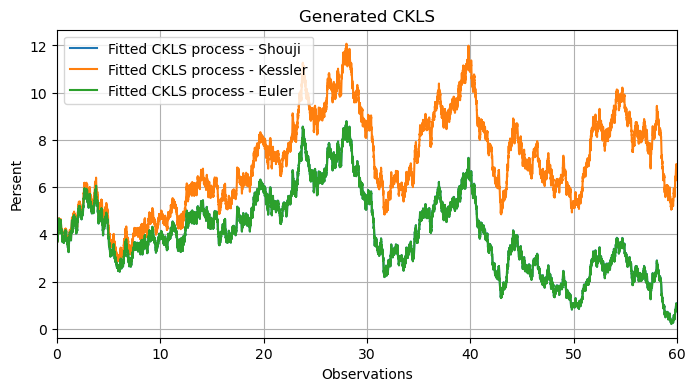

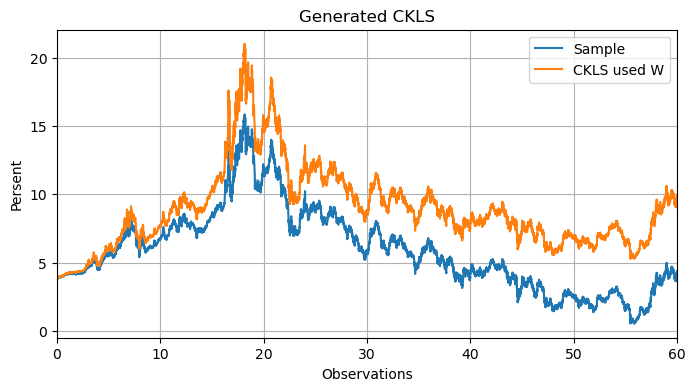

In [33]:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = params_euler
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + processes[MODEL](cev_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + processes[MODEL](cev_k[i-1], params_kessler_CKLS_p[0], params_kessler_CKLS_p[1], params_kessler_CKLS_p[2], params_kessler_CKLS_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + processes[MODEL](cev_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + processes[MODEL](ecev[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [34]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    eu_params.append(euler_est)
    oz_params.append(ozaki_est)
    so_params.append(shoji_est)
    ks_params.append(kessler_est)
    ex_params.append(exact_est)

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628847162
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 90, CG iterations: 54, optimality: 7.93e-07, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.01055025 1.04212239]
Final Likelihood: 20150.868193153015
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.52 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3248.0865903621607
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 332, CG iterations: 193, optimality: 2.87e-05, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.06935714 5.93

c:\miniconda3\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899945.2955203764
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 365, CG iterations: 224, optimality: 4.18e-03, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.07609176 6.09690427 0.5895494  0.31968485]
Final Likelihood: 20927.88183340238
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3246.950994633818
`xtol` termination condition is satisfied.
Number of iterations: 58, function evaluations: 244, CG iterations: 132, optimality: 3.64e-02, constraint violation: 0.00e+00, execution time:  0.3 s.
Final Params: [0.10645611 5.93599994 0.44799895]
Final Likelihood: 20644.38187750568
Initial Params: [0.01, 0.2]
Ini

100%|██████████| 1/1 [00:13<00:00, 13.87s/it]

`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 370, CG iterations: 186, optimality: 1.71e-04, constraint violation: 0.00e+00, execution time: 0.39 s.
Final Params: [0.03825314 0.01000077 0.59008064 0.31925311]
Final Likelihood: 20925.876367201276


Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [35]:
for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_params  = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -102935.02628847162
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 90, CG iterations: 54, optimality: 7.93e-07, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [0.01055025 1.04212239]
Final Likelihood: 20150.868193153015
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -899939.991161753
`xtol` termination condition is satisfied.
Number of iterations: 84, function evaluations: 425, CG iterations: 210, optimality: 1.81e-04, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [0.06865678 6.061304   0.5898921  0.3193843 ]
Final Likelihood: 20927.52090154641
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 3248.0865903621607
`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 332, CG iterations: 193, optimality: 2.87e-05, constraint violation: 0.00e+00, execution time: 0.35 s.
Final Params: [0.06935714 5.93

100%|██████████| 1/1 [00:40<00:00, 40.06s/it]

`xtol` termination condition is satisfied.
Number of iterations: 70, function evaluations: 370, CG iterations: 186, optimality: 1.71e-04, constraint violation: 0.00e+00, execution time:  0.4 s.
Final Params: [0.03825314 0.01000077 0.59008064 0.31925311]
Final Likelihood: 20925.876367201276


In [36]:
models = ['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']

In [37]:
get_results(models, euler_est_aic, euler_params)

AIC values for Shoji-Ozaki estimation:
         -40297.736 - BM model with params [0.01055025 1.04212239],
         -41847.042 - CEV model with params [0.06865678 6.061304   0.5898921  0.3193843 ],
         -41279.321 - CIR model with params [0.06935714 5.93322133 0.44602436],
         -34137.874 - GBM model with params [0.03388114 0.24486267],
         -34156.485 - IGBM model with params [0.14234825 5.17145521 0.24469931],
         -40297.723 - OU model with params [0.06307075 6.01321481 1.04205537],
         -41843.753 - CKLS model with params [0.03825314 0.01000077 0.59008064 0.31925311],
         
The best model is CEV         with param [0.06865678 6.061304   0.5898921  0.3193843 ]


1

In [ ]:
get_results(models, euler_est_bic, euler_params)


AIC values for Shoji-Ozaki estimation:
         -40282.446 - BM model with params [0.01055025 1.04212239],
         -41816.461 - CEV model with params [0.06865678 6.061304   0.5898921  0.3193843 ],
         -41256.386 - CIR model with params [0.06935714 5.93322133 0.44602436],
         -34122.584 - GBM model with params [0.03388114 0.24486267],
         -34133.550 - IGBM model with params [0.14234825 5.17145521 0.24469931],
         -40274.788 - OU model with params [0.06307075 6.01321481 1.04205537],
         -41813.172 - CKLS model with params [0.03825314 0.01000077 0.59008064 0.31925311],
         
The best model is CEV         with param [0.06865678 6.061304   0.5898921  0.3193843 ]


1

In [39]:
get_results(models, shoji_est_aic, shoji_ozaki_params)

AIC values for Shoji-Ozaki estimation:
         -40297.736 - BM model with params [0.01055339 1.04212238],
         -41844.009 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -41276.260 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -34137.874 - GBM model with params [0.0341869  0.24484606],
         -34156.485 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         -40296.113 - OU model with params [0.01274842 0.40623348 1.04213606],
         -41843.751 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is CEV         with param [0.0113267  0.22271155 0.59021228 0.31912468]


1

In [40]:
get_results(models, shoji_est_bic, shoji_ozaki_params)

AIC values for Shoji-Ozaki estimation:
         -40282.446 - BM model with params [0.01055339 1.04212238],
         -41813.429 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -41253.324 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -34122.583 - GBM model with params [0.0341869  0.24484606],
         -34133.549 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         -40273.177 - OU model with params [0.01274842 0.40623348 1.04213606],
         -41813.170 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is CEV         with param [0.0113267  0.22271155 0.59021228 0.31912468]


1

In [41]:
get_results(models, kessler_est_aic, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -40297.718 - BM model with params [0.02687632 1.04212282],
         -41840.017 - CEV model with params [0.04973794 0.12308258 0.58965203 0.32086411],
         -41276.213 - CIR model with params [0.01007676 0.01004482 0.44607708],
         -34128.195 - GBM model with params [0.04306224 0.24453044],
         -34162.881 - IGBM model with params [0.2021986  4.87155722 0.24426688],
         -40296.110 - OU model with params [0.01456313 0.40884138 1.04211052],
         -41843.170 - CKLS model with params [0.10124157 0.01391757 0.59080348 0.31814813],
         
The best model is CKLS         with param [0.10124157 0.01391757 0.59080348 0.31814813]


6

In [42]:
get_results(models, kessler_est_bic, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -40282.427 - BM model with params [0.02687632 1.04212282],
         -41809.437 - CEV model with params [0.04973794 0.12308258 0.58965203 0.32086411],
         -41253.278 - CIR model with params [0.01007676 0.01004482 0.44607708],
         -34112.905 - GBM model with params [0.04306224 0.24453044],
         -34139.946 - IGBM model with params [0.2021986  4.87155722 0.24426688],
         -40273.174 - OU model with params [0.01456313 0.40884138 1.04211052],
         -41812.589 - CKLS model with params [0.10124157 0.01391757 0.59080348 0.31814813],
         
The best model is CKLS         with param [0.10124157 0.01391757 0.59080348 0.31814813]


6

In [43]:
# Implement multiprocessing approach for solving
import multiprocessing
def MLE_Estimator(i):
    # a) fit using Kessler method:

    # Choose several models:
    model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
             IGBM(), OrnsteinUhlenbeck(), CKLS()]

    # Create parametrization templates:
    param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                    [(0.01, 10), (0.01, 2)],                         # GBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                    [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
                   ]

    param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                    [0.01, 0.01, 0.01, 0.2],                         # CEV
                    [0.01, 0.01, 0.2],                               # CIR
                    [0.01, 0.2],                                     # GBM
                    [0.01, 0.01, 0.2],                               # IGBM
                    [0.01, 0.01, 0.2],                               # OU
                    [0.01, 0.01, 0.01, 0.2]                          # CKLS
                   ]

    #pb = param_bounds[0]
    #pg = np.array([1., 0.5])
    #m = BrownianMotion()

    # Set parameters for estimators:
    dt = 1. / 252
    K = 1
    eu_params = []
    oz_params = []
    so_params = []
    ks_params = []
    ex_params = []

    #euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

    for k in tqdm(range(K)):
        seed = rnd.randint(1, 10000)
        euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        ozaki_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        shoji_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        kessler_est = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        exact_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                     for i in range (len(param_bounds))]
        eu_params.append(euler_est)
        oz_params.append(ozaki_est)
        so_params.append(shoji_est)
        ks_params.append(kessler_est)
        ex_params.append(exact_est)
    return [eu_params,
            oz_params,
            so_params,
            ks_params,
            ex_params]

In [ ]:
# Run estimator with parallel calculating:
K = 100
i_range   = [i for i in range(100)]
pool_obj = multiprocessing.Pool()
answer = pool_obj.map(MLE_Estimator, i_range)

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [43]:
df_DEXUSEU = pd.read_csv('./DEXUSEU.csv')
df_DEXUSEU.head()

,DATE,DEXUSEU
0,1999-01-04,1.1812
1,1999-01-05,1.1760
2,1999-01-06,1.1636
3,1999-01-07,1.1672
4,1999-01-08,1.1554


In [44]:
df_DEXUSEU = df_DEXUSEU[df_DEXUSEU['DEXUSEU'] != '.']
sample = df_DEXUSEU['DEXUSEU'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

df_DEXUSEU['DEXUSEU'] = np.float64(df_DEXUSEU.DEXUSEU)
df_DEXUSEU['DATE'] = pd.to_datetime(df_DEXUSEU.DATE)

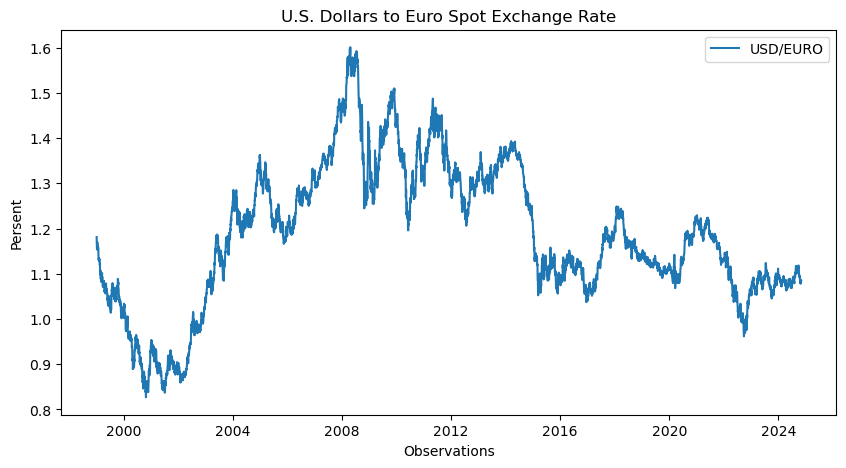

In [45]:
# Plot

figure, ax = plt.subplots(figsize=(10,5))
ax.plot(df_DEXUSEU['DATE'], df_DEXUSEU['DEXUSEU'], label='USD/EURO')
plt.title('U.S. Dollars to Euro Spot Exchange Rate')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [46]:
def CIR_pr(dx, theta1, theta2, theta3, theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw

processes['CIR'] = CIR_pr

def OU_pr(dx, theta1, theta2, theta3,theta4, dt, dw):
    return (theta1 - theta2 * dx) * dt + theta3 * dw

processes['OU'] = OU_pr

In [47]:
models = ['CEV', 'CIR', 'OU', 'CKLS']

In [79]:
def get_res_and_plot(model_name, model):
    euler_CKLS, shoji_Ozaki_CKLS, kessler_CKLS = (ModelEstimator(sample, model_name=model_name, models=model),
                                                ModelEstimator(sample, model_name=model_name, models=model),
                                                ModelEstimator(sample, model_name=model_name, models=model)
    )
    params_euler = (euler_CKLS.fit_euler())[1]
    params_shoji = (shoji_Ozaki_CKLS.fit_shoji_ozaki())[1]
    params_kessler_CKLS = (kessler_CKLS.fit_kessler())[1]


    params_euler_p = params_euler[0].tolist()
    params_shoji_p = params_shoji[0].tolist()
    params_kessler_CKLS_p = params_kessler_CKLS[0].tolist()


    print(len(params_euler_p), len(params_kessler_CKLS_p),
            len(params_shoji_p))


    
    MODEL = model_name

    T = 60
    N = len(sample)

    S0 = sample[0]
    # Set params that were fitted:
    #kappa, mu, sigma, gamma = shoji_ozaki_p
    kappa, mu, sigma, gamma = kessler_p
    #kappa, mu, sigma, gamma = params_euler
    time_line, dt = np.linspace(0, T, N, retstep=True)
    W = Wiener_proc(N, T)
    cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
    cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
    ecev = np.zeros(N)
    ecev[0] = S0
    
    for i in range(1, N):
        dW = W[i] - W[i-1]
        cev_s[i] = cev_s[i-1] + processes[MODEL](cev_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW)
        cev_k[i] = cev_k[i-1] + processes[MODEL](cev_k[i-1], params_kessler_CKLS_p[0], params_kessler_CKLS_p[1], params_kessler_CKLS_p[2], params_kessler_CKLS_p[3], dt, dW)
        cev_e[i] = cev_e[i-1] + processes[MODEL](cev_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW)
        ecev[i] = ecev[i-1] + processes[MODEL](ecev[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1])

    ax, figure = plt.subplots(figsize=(8, 4))
    plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
    plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
    plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
    plt.title(f"Generated {MODEL}")
    plt.ylabel('Persent')
    plt.xlabel('Observations')
    plt.legend()
    plt.xlim(0, T)
    plt.grid()
    plt.show()

    ax, figure = plt.subplots(figsize=(8, 4))
    plt.plot(time_line, sample, label="Sample")
    plt.plot(time_line, ecev, label=f'{MODEL} used W')
    plt.title(f"Generated {MODEL}")
    plt.ylabel('Persent')
    plt.xlabel('Observations')
    plt.legend()
    plt.xlim(0, T)
    plt.grid()
    plt.show()



Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756
`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 176, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [9.99978668 0.01002966 3.29758823 0.58943751]
Final Likelihood: -326.0594280917877
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756
`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 176, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [9.99978668 0.01002966 3.29758823 0.58943751]
Final Likelihood: -326.0594280917877
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.20942956937
`xtol` termination condition is satisfied.
Number of iterations: 72, function evaluations: 435, CG iterations: 229, optimality: 1.09e+01, constraint violation: 0.00e+00, execution t

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1826396453.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


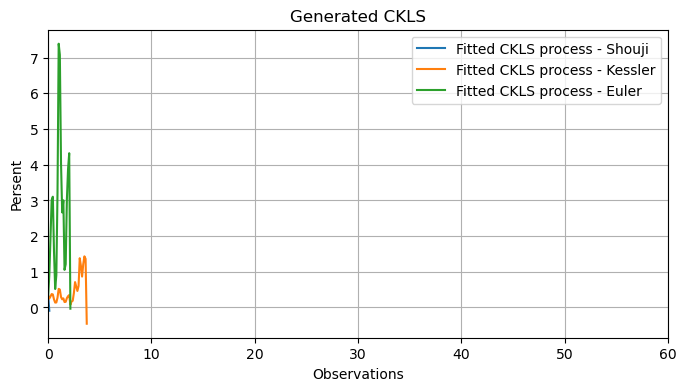

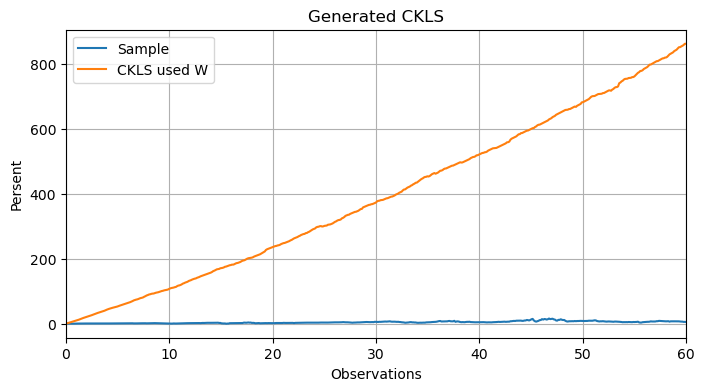

In [80]:
model = CKLS()
MODEL = "CKLS"

get_res_and_plot(MODEL, model)

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611512959173
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611512959173
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147681.96692968498
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1123020714.py:11: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


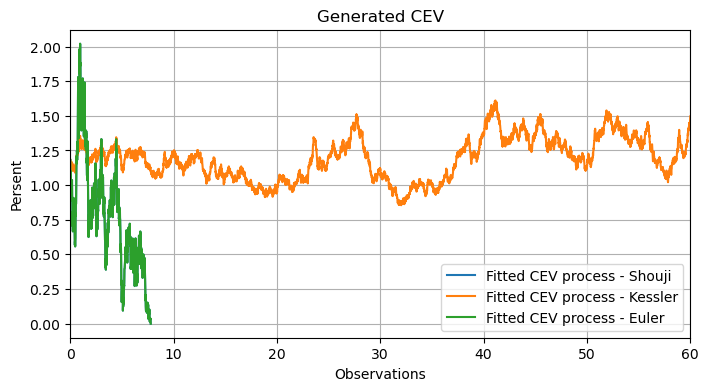

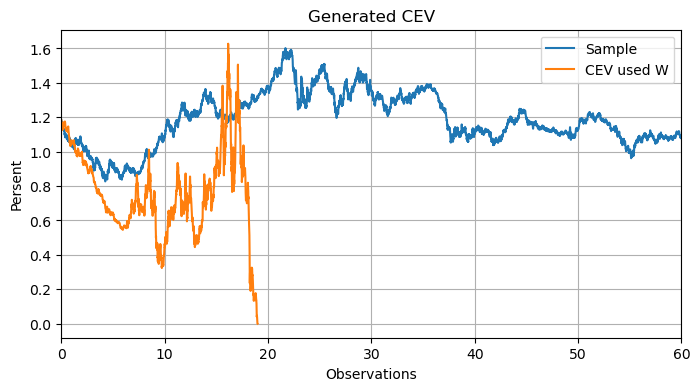

In [50]:
model = CEV()
MODEL = "CEV"

get_res_and_plot(MODEL, model)

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.768266444138


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 404, CG iterations: 199, optimality: 1.69e-04, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.2456409  1.17019755 0.11108683]
Final Likelihood: 22960.059512073145
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.768266444138
`xtol` termination condition is satisfied.
Number of iterations: 100, function evaluations: 404, CG iterations: 199, optimality: 1.69e-04, constraint violation: 0.00e+00, execution time: 0.32 s.
Final Params: [0.2456409  1.17019755 0.11108683]
Final Likelihood: 22960.059512073145
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21389.857153714584
`xtol` termination condition is satisfied.
Number of iterations: 98, function evaluations: 384, CG iterations: 216, optimality: 5.79e-04, constraint violation: 0.00e+00, execution time: 0.42 s.
Final Params: [0.24594402 1.17021599 0.11114103]
Final Likelihood: 22960.059511057625
Initial Para

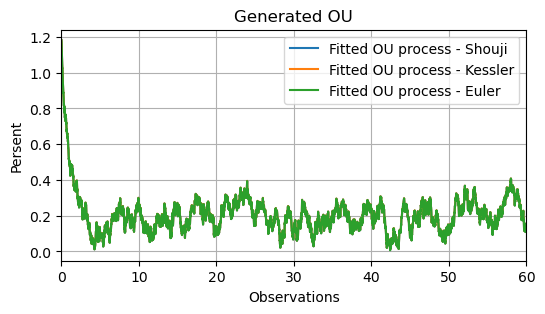

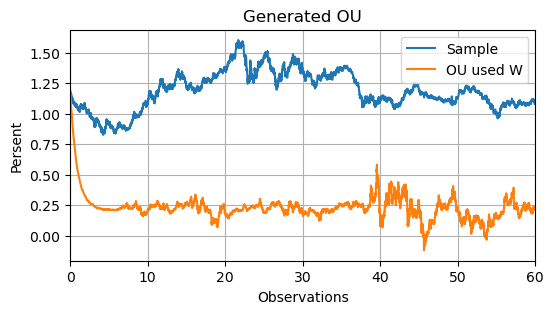

In [51]:

euler_OU, shoji_Ozaki_OU, kessler_OU = (ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck())
)
params_euler = (euler_OU.fit_euler())[1]
params_shoji = (shoji_Ozaki_OU.fit_shoji_ozaki())[1]
params_kessler_OU = (kessler_OU.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_OU = params_kessler_OU[0].tolist()

T = 60
N = len(sample)


MODEL = "OU"

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_OU
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], params_kessler_OU[0], params_kessler_OU[1], params_kessler_OU[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [75]:
euler_CIR, shoji_Ozaki_CIR, kessler_CIR = (ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR())
)
params_euler = (euler_CIR.fit_euler())[1]
params_shoji = (shoji_Ozaki_CIR.fit_shoji_ozaki())[1]
params_kessler_CIR = (kessler_CIR.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_CIR_p = params_kessler_CIR[0].tolist()

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.05e-01, constraint violation: 0.00e+00, execution time: 0.76 s.
Final Params: [0.38244994 1.48585977 1.99984903]
Final Likelihood: -671.3746541869693
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.05e-01, constraint violation: 0.00e+00, execution time: 0.78 s.
Final Params: [0.38244994 1.48585977 1.99984903]
Final Likelihood: -671.3746541869693
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.742102094562
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 172, CG iterations: 75, optimality: 9.98e+00, constraint violation: 0.00e+00, execution time: 0.091

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\4114572489.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw


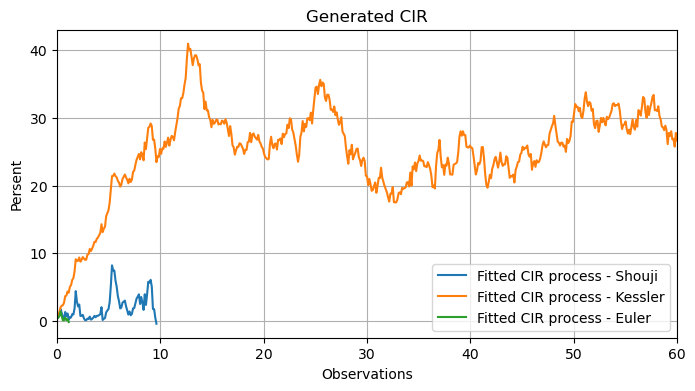

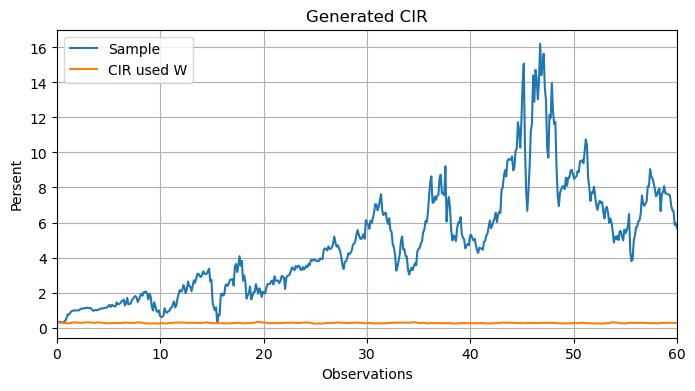

In [76]:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_CIR_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cir_s, cir_k, cir_e = np.zeros(N), np.zeros(N), np.zeros(N)
cir_s[0], cir_k[0], cir_e[0] = S0, S0, S0
ecir = np.zeros(N)
ecir[0] = S0

MODEL = "CIR"

for i in range(1, N):
    dW = W[i] - W[i-1]
    cir_s[i] = cir_s[i-1] + processes[MODEL](cir_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW)
    cir_k[i] = cir_k[i-1] + processes[MODEL](cir_k[i-1], params_kessler_CIR_p[0], kessler_p[1], kessler_p[2], gamma, dt, dW)
    cir_e[i] = cir_e[i-1] + processes[MODEL](cir_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW)
    ecir[i] = ecir[i-1] + processes[MODEL](ecir[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cir_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cir_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cir_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecir, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [56]:

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []



for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: 21389.69046908656
`xtol` termination condition is satisfied.
Number of iterations: 51, function evaluations: 156, CG iterations: 82, optimality: 8.21e-05, constraint violation: 0.00e+00, execution time: 0.15 s.
Final Params: [0.0100299  0.11111645]
Final Likelihood: 22958.332731301463
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147678.57260201464
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.2337731  0.23392371 0.6292321  0.35952845]
Final Likelihood: 14497.611512959173
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21042.96300835637
`xtol` termination condition is satisfied.
Number of iterations: 102, function evaluations: 384, CG iterations: 193, optimality: 3.44e-06, constraint violation: 0.00e+00, execution time: 0.36 s.
Final Params:

c:\miniconda3\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -147681.93768298533
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.77e+03, constraint violation: 0.00e+00, execution time:  1.2 s.
Final Params: [0.23386944 0.23390649 0.62926647 0.35953709]
Final Likelihood: 14499.594585056358
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 21043.05804556309
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 208, CG iterations: 116, optimality: 7.53e-03, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [0.22779223 1.16901169 0.10084817]
Final Likelihood: 23063.980452718824
Initial Param

100%|██████████| 1/1 [01:03<00:00, 63.08s/it]

The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1250, CG iterations: 743, optimality: 2.76e+03, constraint violation: 0.00e+00, execution time:  1.0 s.
Final Params: [0.23379757 0.23374217 0.63008097 0.35973871]
Final Likelihood: 14482.667790110885


In [61]:
models = ['BM', 'CEV', 'CIR', 'GBM', 'IGBM', 'OU', 'CKLS']

In [66]:
get_results(models, euler_est_aic, euler_params)
print()
print('=========================================================================================')
print()
get_results(models, euler_est_bic, euler_params)

AIC values for Shoji-Ozaki estimation:
         -45912.665 - BM model with params [0.0100299  0.11111645],
         -28987.223 - CEV model with params [0.2337731  0.23392371 0.6292321  0.35952845],
         -46122.084 - CIR model with params [0.23244703 1.16933002 0.10084736],
         -46198.347 - GBM model with params [0.01000596 0.09250109],
         -46199.418 - IGBM model with params [0.22379477 1.16951722 0.09247918],
         -45914.119 - OU model with params [0.2456409  1.17019755 0.11108683],
         -28957.336 - CKLS model with params [0.23379757 0.23374217 0.63008097 0.35973871],
         
The best model is IGBM         with param [0.22379477 1.16951722 0.09247918]


AIC values for Shoji-Ozaki estimation:
         -45899.113 - BM model with params [0.0100299  0.11111645],
         -28960.117 - CEV model with params [0.2337731  0.23392371 0.6292321  0.35952845],
         -46101.755 - CIR model with params [0.23244703 1.16933002 0.10084736],
         -46184.794 - GBM model wi

3

In [ ]:

get_results(models, shoji_est_aic, shoji_ozaki_params)
print()
print('=========================================================================================')
print()
get_results(models, shoji_est_bic, shoji_ozaki_params)

AIC values for Shoji-Ozaki estimation:
         -45912.667 - BM model with params [0.01055339 1.04212238],
         -28992.060 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -46122.084 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -46198.346 - GBM model with params [0.0341869  0.24484606],
         -46199.418 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         -45914.119 - OU model with params [0.01274842 0.40623348 1.04213606],
         -28952.507 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is IGBM         with param [0.14231153 5.1889788  0.24476733]


AIC values for Shoji-Ozaki estimation:
         -45899.114 - BM model with params [0.01055339 1.04212238],
         -28964.954 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -46101.755 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -46184.793 - GBM model wi

3

In [68]:
get_results(models, kessler_est_aic, kessler_params)
print()
print('=========================================================================================')
print()
get_results(models, kessler_est_bic, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -45912.667 - BM model with params [0.01000564 0.11111643],
         -46197.729 - CEV model with params [0.21178022 1.17607564 0.0919237  1.03591483],
         -46120.541 - CIR model with params [0.06475713 1.23051089 0.10084929],
         -46198.336 - GBM model with params [0.01022798 0.09248048],
         -46199.421 - IGBM model with params [0.22538565 1.16933616 0.09246054],
         -45914.120 - OU model with params [0.2466065  1.17035888 0.11108682],
         -45953.202 - CKLS model with params [0.32315242 0.01012719 0.09518806 0.94894251],
         
The best model is IGBM         with param [0.22538565 1.16933616 0.09246054]


AIC values for Shoji-Ozaki estimation:
         -45899.114 - BM model with params [0.01000564 0.11111643],
         -46170.623 - CEV model with params [0.21178022 1.17607564 0.0919237  1.03591483],
         -46100.212 - CIR model with params [0.06475713 1.23051089 0.10084929],
         -46184.783 - GBM model wi

3

---

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [69]:

#sigma, gamma,alpha, beta
params = [0.13, 1.44, 2.08, - 0.26,]

In [70]:
# your code
data = {'1946': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 0.325],
        '1947':	[0.322, 0.326, 0.318, 0.302, 0.288, 0.328, 0.378, 0.528, 0.742, 0.732, 0.814, 0.904],
        '1948':	[0.959, 0.968, 0.978, 0.984, 0.987, 0.975, 0.992, 1.063, 1.082, 1.084, 1.101, 1.110],
        '1949':	[1.126, 1.139, 1.114, 1.123, 1.092, 1.016, 0.960, 0.982, 1.010, 0.985, 1.011, 1.035],
        '1950':	[1.072, 1.100, 1.084, 1.112, 1.136, 1.129, 1.158, 1.246, 1.291, 1.184, 1.307, 1.250],
        '1951':	[1.209, 1.210, 1.439, 1.329, 1.344, 1.382, 1.491, 1.538, 1.596, 1.258, 1.388, 1.696],
        '1952':	[1.332, 1.342, 1.374, 1.579, 1.642, 1.747, 1.802, 1.712, 1.459, 1.589, 1.781, 1.941],
        '1953':	[1.819, 2.019, 1.987, 2.062, 1.935, 1.606, 1.936, 1.790, 1.220, 0.975, 1.439, 1.248],
        '1954':	[0.958, 0.887, 0.985, 0.673, 0.603, 0.620, 0.679, 1.107, 0.903, 0.845, 0.929, 0.949],
        '1955':	[1.097, 1.139, 1.328, 1.496, 1.152, 1.271, 1.667, 1.948, 2.145, 2.052, 2.111, 2.424],
        '1956':	[2.278, 1.969, 2.198, 2.628, 2.374, 2.333, 2.082, 2.396, 2.700, 2.560, 2.806, 3.077],
        '1957':	[3.064, 2.938, 2.886, 3.021, 3.210, 3.083, 3.056, 3.072, 3.228, 3.361, 2.635, 2.728],
        '1958':	[1.456, 1.137, 0.990, 1.155, 0.249, 0.747, 0.704, 1.872, 1.949, 1.822, 1.904, 2.419],
        '1959':	[2.467, 2.379, 2.567, 2.739, 2.747, 2.774, 2.399, 3.477, 3.638, 3.169, 3.531, 4.079],
        '1960':	[3.538, 3.807, 2.683, 2.970, 2.596, 1.655, 1.831, 1.972, 2.340, 1.606, 1.789, 2.026],
        '1961':	[2.039, 2.482, 2.192, 1.933, 2.239, 2.078, 1.744, 2.047, 1.992, 1.957, 2.278, 2.483],
        '1962': [2.485, 2.485, 2.632, 2.694, 2.455, 2.928, 2.685, 2.661, 2.686, 2.533, 2.671, 2.941],
        '1963':	[2.928, 2.842, 2.204, 2.853, 2.950, 2.975, 3.053, 3.264, 3.437, 3.364, 3.274, 3.511],
        '1964':	[3.424, 3.528, 3.513, 3.320, 3.289, 3.456, 3.317, 3.398, 3.526, 3.451, 3.631, 3.561],
        '1965':	[3.854, 3.866, 3.822, 3.885, 3.863, 3.787, 3.812, 3.807, 3.949, 3.917, 3.925, 4.440],
        '1966':	[4.521, 4.497, 4.403, 4.631, 4.495, 4.495, 4.576, 4.792, 5.198, 4.848, 4.624, 4.699],
        '1967':	[4.537, 4.372, 4.014, 3.543, 3.345, 3.748, 3.788, 3.928, 4.248, 4.185, 4.275, 4.426],
        '1968':	[4.739, 4.788, 4.941, 5.335, 5.568, 5.289, 5.102, 5.049, 5.197, 5.336, 5.071, 6.138],
        '1969':	[5.948, 5.892, 5.638, 6.111, 5.971, 6.256, 6.547, 7.047, 7.031, 6.694, 6.892, 7.280],
        '1970':	[7.622, 6.683, 6.425, 6.523, 6.564, 6.119, 5.920, 6.238, 5.557, 5.455, 4.754, 4.572],
        '1971':	[4.113, 3.250, 3.462, 3.807, 4.203, 4.950, 5.206, 4.456, 4.473, 4.057, 4.064, 3.330],
        '1972':	[3.024, 3.250, 3.420, 3.285, 3.503, 3.675, 3.555, 4.346, 4.482, 4.540, 4.793, 4.927],
        '1973':	[5.437, 5.592, 6.083, 6.013, 6.531, 7.454, 8.289, 8.636, 7.126, 7.147, 7.488, 7.292],
        '1974':	[7.518, 7.578, 8.513, 8.727, 7.664, 7.655, 7.553, 9.205, 6.056, 7.117, 7.452, 6.770],
        '1975':	[5.533, 4.977, 5.266, 5.149, 4.940, 5.667, 6.003, 5.980, 6.310, 5.360, 5.125, 5.056],
        '1976':	[4.525, 4.672, 4.778, 4.696, 5.244, 5.296, 5.102, 4.978, 5.068, 4.745, 4.412, 4.263],
        '1977':	[4.566, 4.523, 4.507, 4.442, 4.901, 4.956, 5.248, 5.381, 5.743, 6.111, 5.672, 5.822],
        '1978':	[6.070, 6.226, 6.564, 6.026, 6.442, 6.606, 6.554, 7.875, 7.997, 8.655, 8.989, 8.628],
        '1979':	[9.507, 9.627, 9.589, 9.584, 9.778, 8.977, 9.136, 10.107, 10.218, 11.728, 11.230, 10.274],
        '1980':	[11.871, 13.919, 15.071, 10.389, 7.847, 6.665, 7.835, 9.200, 11.204, 11.657, 14.394, 12.901],
        '1981':	[14.717, 14.197, 13.034, 14.114, 16.210, 14.413, 14.980, 15.639, 13.679, 12.972, 10.237, 9.710],
        '1982':	[12.141, 11.980, 13.963, 12.316, 11.616, 11.742, 9.147, 7.513, 6.937, 7.722, 7.873, 8.071],
        '1983':	[8.066, 7.909, 8.558, 8.099, 8.559, 8.568, 8.955, 9.008, 8.775, 8.491, 8.576, 8.633],
        '1984':	[8.940, 8.863, 9.504, 9.488, 9.558, 9.386, 10.029, 10.743, 10.442, 8.570, 8.000, 7.229],
        '1985':	[7.725, 7.671, 8.037, 7.516, 6.996, 6.719, 7.056, 7.243, 7.109, 7.165, 6.592, 6.237],
        '1986':	[6.805, 6.887, 6.579, 5.981, 6.234, 6.006, 5.499, 4.859, 5.202, 5.033, 5.241, 4.998],
        '1987':	[5.510, 5.489, 5.201, 4.984, 5.597, 5.397, 5.546, 5.805, 6.484, 4.364, 3.800, 3.880],
        '1988':	[4.930, 5.267, 5.730, 5.768, 6.083, 6.128, 6.524, 7.544, 7.073, 6.957, 7.084, 7.196],
        '1989':	[8.066, 8.075, 9.043, 8.630, 8.519, 8.254, 7.934, 7.501, 7.588, 7.842, 7.938, 6.651],
        '1990':	[7.627, 7.740, 8.083, 7.666, 7.652, 7.613, 7.596, 7.537, 6.959, 6.709, 6.659, 5.867],
        '1991':	[5.953, 5.677, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan] 									       	     
        }

In [71]:
dates, values = [], []
monthes = {i: f"{i+1:02d}" for i in range(12)}  # словарь {0: '01', 1: '02', ...}

for year, rates in data.items():
    for i, rate in enumerate(rates):
        dates.append(f"{year}-{monthes[i]}-01")
        values.append(rate)


dates = pd.to_datetime(dates)
df = pd.DataFrame({'DATE': dates, 'IR': values})


df.to_csv('InterestRate.csv', index=False)

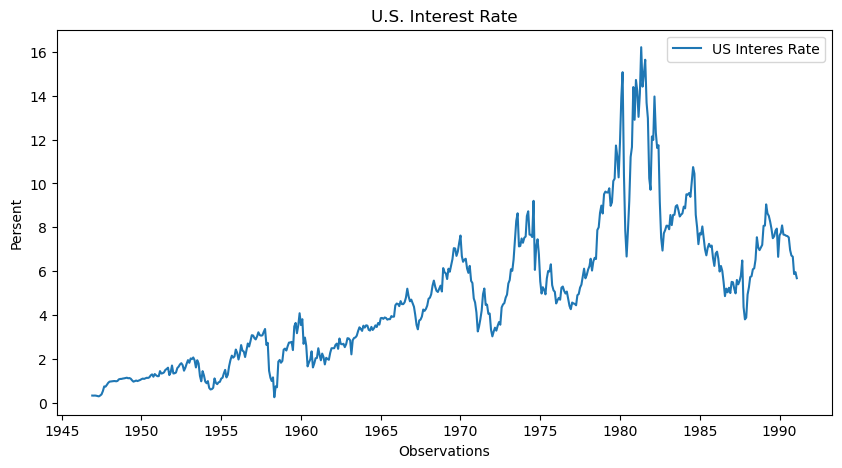

In [73]:
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, values, label='US Interes Rate')
plt.title('U.S. Interest Rate')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [74]:
sample = df.IR.dropna().values

In [82]:
euler_CIR, shoji_Ozaki_CIR, kessler_CIR = (ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR())
)
params_euler = (euler_CIR.fit_euler())[1]
params_shoji = (shoji_Ozaki_CIR.fit_shoji_ozaki())[1]
params_kessler_CIR = (kessler_CIR.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_CIR_p = params_kessler_CIR[0].tolist()

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.05e-01, constraint violation: 0.00e+00, execution time: 0.74 s.
Final Params: [0.38244994 1.48585977 1.99984903]
Final Likelihood: -671.3746541869693
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.05e-01, constraint violation: 0.00e+00, execution time: 0.77 s.
Final Params: [0.38244994 1.48585977 1.99984903]
Final Likelihood: -671.3746541869693
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.742102094562
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 172, CG iterations: 75, optimality: 9.98e+00, constraint violation: 0.00e+00, execution time:  0.1 

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\4114572489.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw


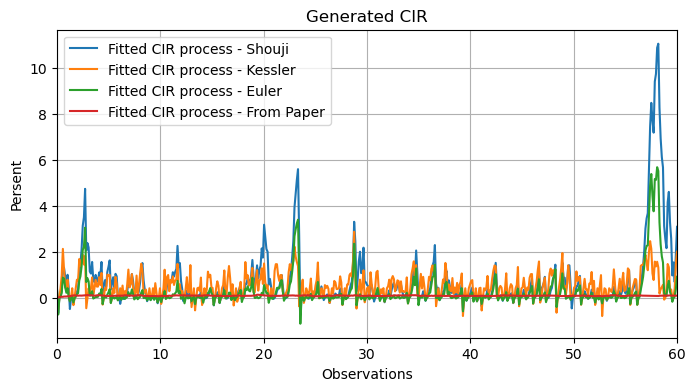

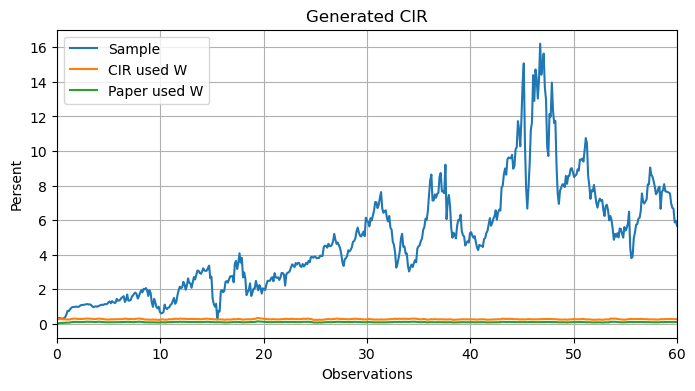

In [85]:
# Set data and generate the process:
T = 60
N = len(sample)

MODEL = "CIR"

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_CIR_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cir_s, cir_k, cir_e = np.zeros(N), np.zeros(N), np.zeros(N)
cir_paper = np.zeros(N)
cir_s[0], cir_k[0], cir_e[0] = S0, S0, S0
ecir = np.zeros(N)
ecir[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cir_s[i] = np.nan_to_num(cir_s[i-1] + processes[MODEL](cir_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW), cir_s[i-1])
    cir_k[i] = np.nan_to_num(cir_k[i-1] + processes[MODEL](cir_k[i-1], params_kessler_CIR_p[0], params_kessler_CIR_p[1], params_kessler_CIR_p[2], gamma, dt, dW), cir_k[i-1])
    cir_e[i] = np.nan_to_num(cir_e[i-1] + processes[MODEL](cir_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW), cir_e[i-1])
    ecir[i] = np.nan_to_num(ecir[i-1] + processes[MODEL](ecir[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1]), ecir[i-1])
    cir_paper[i] = np.nan_to_num(cir_paper[i-1] + processes[MODEL](cir_paper[i-1], params[0], params[1], 
                                                                   params[2], params[3], dt, cW[i-1]), 
                                                                   cir_paper[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cir_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cir_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cir_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, cir_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecir, label=f'{MODEL} used W')
plt.plot(time_line, cir_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [87]:
euler_OU, shoji_Ozaki_OU, kessler_OU = (ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck())
)
params_euler = (euler_OU.fit_euler())[1]
params_shoji = (shoji_Ozaki_OU.fit_shoji_ozaki())[1]
params_kessler_OU = (kessler_OU.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler_OU[0].tolist()

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.443978371175
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 152, CG iterations: 78, optimality: 5.42e-07, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [1.58970424 8.81792132 2.        ]
Final Likelihood: -3403.4327504590406
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.443978371175
`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 152, CG iterations: 78, optimality: 5.42e-07, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [1.58970424 8.81792132 2.        ]
Final Likelihood: -3403.4327504590406
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.622128076182
`xtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 128, CG iterations: 58, optimality: 2.22e-02, constraint violation: 0.00e+00, execution time: 0.083 s.
Final Params: [0.0102905

c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 296, CG iterations: 106, optimality: 7.56e-03, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [1.79836739 8.43934018 1.99999964]
Final Likelihood: -3402.799487230348
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -24678.443880142735
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 296, CG iterations: 106, optimality: 7.56e-03, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [1.79836739 8.43934018 1.99999964]
Final Likelihood: -3402.799487230348


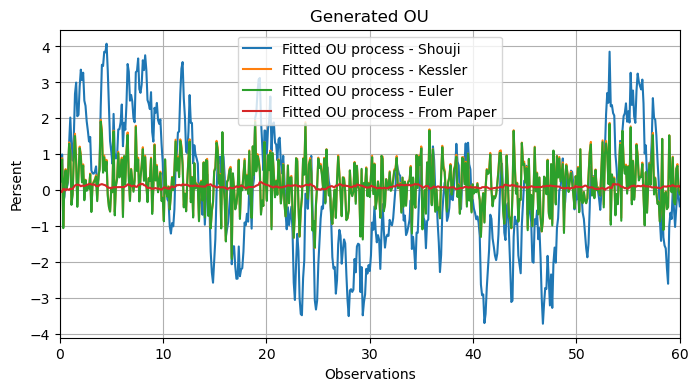

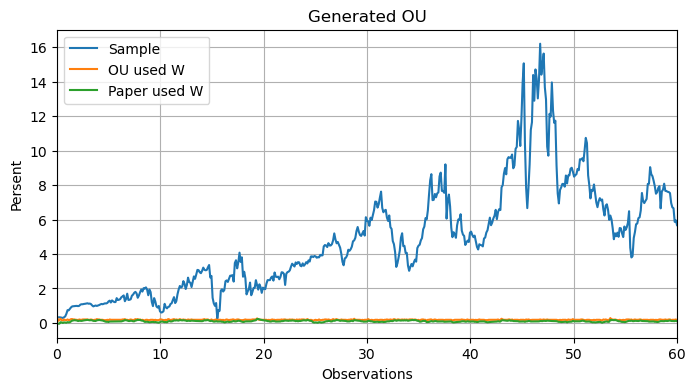

In [89]:
# Set data and generate the process:
T = 60
N = len(sample)
MODEL ="OU"
S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_paper = np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1])
    ou_paper[i] = ou_paper[i-1] + processes[MODEL](ou_paper[i-1], params[0], params[1], 
                                                   params[2], params[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, ou_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.plot(time_line, ou_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [90]:
euler_CKLS, shoji_Ozaki_CKLS, kessler_CKLS = (ModelEstimator(sample, model_name="CKLS", models=CKLS()),
                                            ModelEstimator(sample, model_name="CKLS", models=CKLS()),
                                            ModelEstimator(sample, model_name="CKLS", models=CKLS())
)
params_euler = (euler_CKLS.fit_euler())[1]
params_shoji = (shoji_Ozaki_CKLS.fit_shoji_ozaki())[1]
params_kessler = (kessler_CKLS.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 176, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [9.99978668 0.01002966 3.29758823 0.58943751]
Final Likelihood: -326.0594280917877
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756
`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 176, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [9.99978668 0.01002966 3.29758823 0.58943751]
Final Likelihood: -326.0594280917877
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.20942956937
`xtol` termination condition is satisfied.
Number of iterations: 72, function evaluations: 435, CG iterations: 229, optimality: 1.09e+01, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [1.00120684 1.0112995  3.35887267 0.57864242]
Final 

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1826396453.py:2: RuntimeWarning: divide by zero encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw
C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1826396453.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


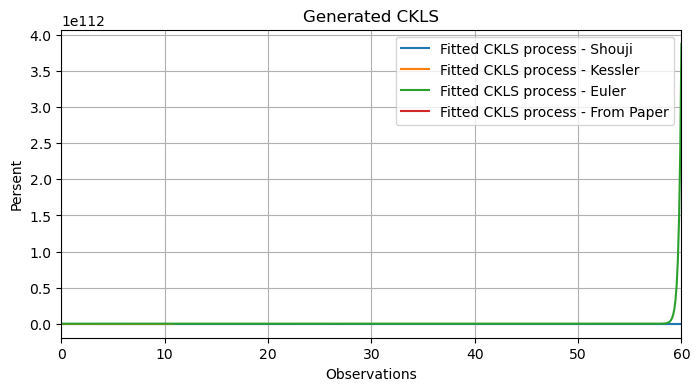

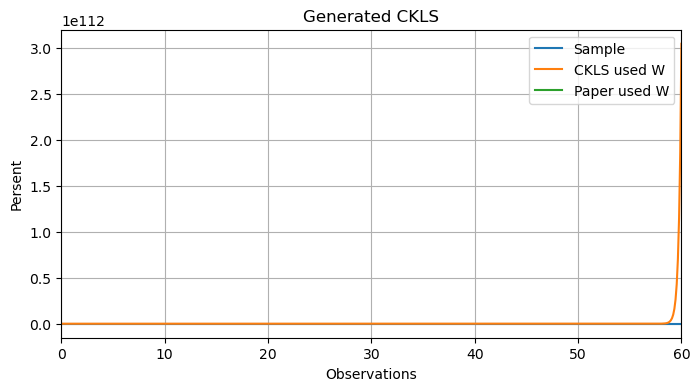

In [111]:
# Set data and generate the process:
T = 60
N = len(sample)
MODEL = "CKLS"
S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = params_kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_paper = np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + processes[MODEL](ckls_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + processes[MODEL](ckls_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], params_kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + processes[MODEL](ckls_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + processes[MODEL](eckls[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1])
    ckls_paper[i] = ckls_paper[i-1] + processes[MODEL](ckls_paper[i-1], params[0], params[1], params[2], params[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, ckls_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ckls_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ckls_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, ckls_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label=f'{MODEL} used W')
plt.plot(time_line, ckls_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [101]:
euler_CEV, shoji_Ozaki_CEV, kessler_CEV = (ModelEstimator(sample, model_name="CEV", models=CEV()),
                                            ModelEstimator(sample, model_name="CEV", models=CEV()),
                                            ModelEstimator(sample, model_name="CEV", models=CEV())
)
params_euler = (euler_CEV.fit_euler())[1]
params_shoji = (shoji_Ozaki_CEV.fit_shoji_ozaki())[1]
params_kessler = (kessler_CEV.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.516707370334
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 345, CG iterations: 210, optimality: 1.42e-06, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [3.34153121 5.56944954 3.27136439 0.59261941]
Final Likelihood: -324.0244868999574
Initial Params: [0.01, 0.01, 0.01, 0.2]


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Initial Likelihood: -35672.516707370334
`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 345, CG iterations: 210, optimality: 1.42e-06, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [3.34153121 5.56944954 3.27136439 0.59261941]
Final Likelihood: -324.0244868999574
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.53579376933
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 335, CG iterations: 194, optimality: 8.54e+00, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [0.92267851 1.01413875 3.39698786 0.57451469]
Final Likelihood: -330.48595944555984
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.53579376933
`xtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 335, CG iterations: 194, optimality: 8.54e+00, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [0.92267851

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1123020714.py:11: RuntimeWarning: divide by zero encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\3208255926.py:22: RuntimeWarning: invalid value encountered in scalar add
  ckls_paper[i] = ckls_paper[i-1] + processes[MODEL](ckls_paper[i-1], params[0], params[1], params[2], params[3], dt, cW[i-1])
C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1123020714.py:11: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


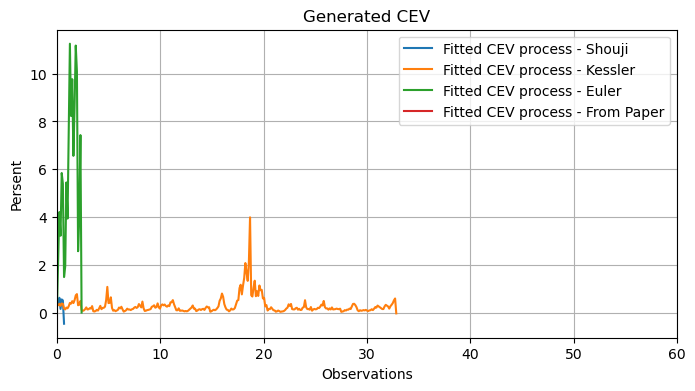

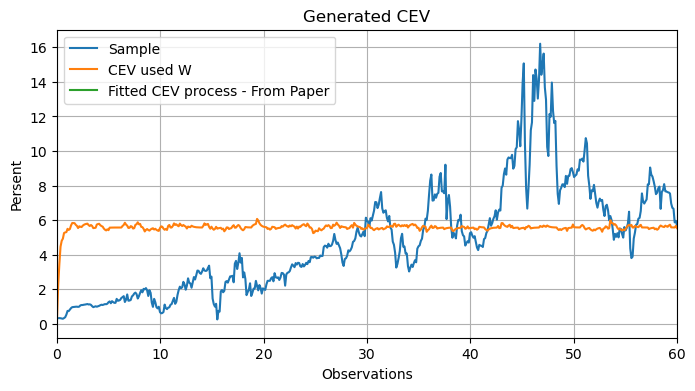

In [ ]:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = params_euler
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + processes[MODEL](cev_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + processes[MODEL](cev_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], params_kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + processes[MODEL](cev_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + processes[MODEL](ecev[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1])
    ckls_paper[i] = ckls_paper[i-1] + processes[MODEL](ckls_paper[i-1], params[0], params[1], params[2], params[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cev_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.plot(time_line, ckls_paper, label=f"Fitted {MODEL} process - From Paper")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.plot(time_line, cev_paper, label=f'Paper used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()



In [112]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 18, function evaluations: 45, CG iterations: 23, optimality: 8.86e-07, constraint violation: 0.00e+00, execution time: 0.05 s.
Final Params: [8.29541608 1.99999964]
Final Likelihood: -3404.7460266736416
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.516707370334


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 73, function evaluations: 345, CG iterations: 210, optimality: 1.42e-06, constraint violation: 0.00e+00, execution time: 0.19 s.
Final Params: [3.34153121 5.56944954 3.27136439 0.59261941]
Final Likelihood: -324.0244868999574
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.50404503303
The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1000, CG iterations: 265, optimality: 6.05e-01, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.38244994 1.48585977 1.99984903]
Final Likelihood: -671.3746541869693
Initial Params: [0.01, 0.2]
Initial Likelihood: -10148.131872440052
`gtol` termination condition is satisfied.
Number of iterations: 35, function evaluations: 84, CG iterations: 46, optimality: 3.31e-07, constraint violation: 0.00e+00, execution time: 0.082 s.
Final Params: [2.26883448 1.82643802]
Final Likelihood: -437.7456200493933
Initi

c:\miniconda3\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


`xtol` termination condition is satisfied.
Number of iterations: 79, function evaluations: 360, CG iterations: 236, optimality: 1.08e-04, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [4.01613053 5.35476241 3.1185262  0.61849102]
Final Likelihood: -321.166933144113
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18254.741282245264
`xtol` termination condition is satisfied.
Number of iterations: 81, function evaluations: 344, CG iterations: 153, optimality: 7.69e-05, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [2.98749268 7.30614916 1.99999995]
Final Likelihood: -642.6616357208213
Initial Params: [0.01, 0.2]
Initial Likelihood: -10147.902728202875
`xtol` termination condition is satisfied.
Number of iterations: 39, function evaluations: 78, CG iterations: 58, optimality: 7.23e-06, constraint violation: 0.00e+00, execution time: 0.095 s.
Final Params: [2.25868574 1.81825889]
Final Likelihood: -437.74562004940367
Initial Params: [0.

100%|██████████| 1/1 [00:17<00:00, 17.21s/it]

`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 152, CG iterations: 78, optimality: 5.42e-07, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [1.58970424 8.81792132 2.        ]
Final Likelihood: -3403.4327504590406
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22830766756
`gtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 295, CG iterations: 176, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.16 s.
Final Params: [9.99978668 0.01002966 3.29758823 0.58943751]
Final Likelihood: -326.0594280917877


In [115]:
get_results(models, euler_est_aic, euler_params)
print()
print('=========================================================================================')
print()
get_results(models, euler_est_bic, euler_params)

AIC values for Shoji-Ozaki estimation:
         6813.492 - BM model with params [8.29541608 1.99999964],
         656.049 - CEV model with params [3.34153121 5.56944954 3.27136439 0.59261941],
         1348.749 - CIR model with params [0.38244994 1.48585977 1.99984903],
         879.491 - GBM model with params [2.26883448 1.82643802],
         873.715 - IGBM model with params [0.77595117 9.98335743 1.81303735],
         6812.866 - OU model with params [1.58970424 8.81792132 2.        ],
         660.119 - CKLS model with params [9.99978668 0.01002966 3.29758823 0.58943751],
         
The best model is CEV         with param [3.34153121 5.56944954 3.27136439 0.59261941]


AIC values for Shoji-Ozaki estimation:
         6822.038 - BM model with params [8.29541608 1.99999964],
         673.140 - CEV model with params [3.34153121 5.56944954 3.27136439 0.59261941],
         1361.568 - CIR model with params [0.38244994 1.48585977 1.99984903],
         888.037 - GBM model with params [2.26883

1

In [ ]:

get_results(models, shoji_est_aic, shoji_ozaki_params)
print()
print('=========================================================================================')
print()
get_results(models, shoji_est_bic, shoji_ozaki_params)


AIC values for Shoji-Ozaki estimation:
         6813.490 - BM model with params [0.01055339 1.04212238],
         668.972 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         1354.584 - CIR model with params [0.0250517  2.42993256 0.44609072],
         880.734 - GBM model with params [0.0341869  0.24484606],
         885.123 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         6847.272 - OU model with params [0.01274842 0.40623348 1.04213606],
         667.367 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is CKLS         with param [0.03828952 0.01002051 0.59006865 0.31925333]


AIC values for Shoji-Ozaki estimation:
         6822.036 - BM model with params [0.01055339 1.04212238],
         686.063 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         1367.402 - CIR model with params [0.0250517  2.42993256 0.44609072],
         889.280 - GBM model with params [0.0341

6

In [117]:
get_results(models, kessler_est_aic, kessler_params)
print()
print('=========================================================================================')
print()
get_results(models, kessler_est_bic, kessler_params)

AIC values for Shoji-Ozaki estimation:
         6813.492 - BM model with params [8.29453792 1.99999964],
         1009.609 - CEV model with params [0.41136233 0.41961824 1.32213491 1.08923505],
         1290.379 - CIR model with params [3.69075795 5.95070531 1.99987   ],
         887.787 - GBM model with params [0.86186178 1.79631468],
         876.433 - IGBM model with params [1.44868411 6.56324301 1.7438952 ],
         6811.599 - OU model with params [1.79836739 8.43934018 1.99999964],
         942.022 - CKLS model with params [0.49121258 0.49176847 1.54405065 1.082979  ],
         
The best model is IGBM         with param [1.44868411 6.56324301 1.7438952 ]


AIC values for Shoji-Ozaki estimation:
         6822.038 - BM model with params [8.29453792 1.99999964],
         1026.701 - CEV model with params [0.41136233 0.41961824 1.32213491 1.08923505],
         1303.197 - CIR model with params [3.69075795 5.95070531 1.99987   ],
         896.333 - GBM model with params [0.86186178 1.79

4

---

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [119]:
!pip install yfinance

     ---------------------------------------- 0.0/939.5 kB ? eta -:--:--
     ---------------------------------------- 10.2/939.5 kB ? eta -:--:--
     - ----------------------------------- 30.7/939.5 kB 660.6 kB/s eta 0:00:02
     - ----------------------------------- 41.0/939.5 kB 326.8 kB/s eta 0:00:03
     --- --------------------------------- 92.2/939.5 kB 525.1 kB/s eta 0:00:02
     ---- ------------------------------- 122.9/939.5 kB 554.9 kB/s eta 0:00:02
     ----- ------------------------------ 143.4/939.5 kB 607.9 kB/s eta 0:00:02
     -------- --------------------------- 225.3/939.5 kB 765.3 kB/s eta 0:00:01
     ---------- ------------------------- 266.2/939.5 kB 780.5 kB/s eta 0:00:01
     -------------- --------------------- 389.1/939.5 kB 969.0 kB/s eta 0:00:01
     -------------------- ----------------- 501.8/939.5 kB 1.2 MB/s eta 0:00:01
     --------------------- ---------------- 532.5/939.5 kB 1.2 MB/s eta 0:00:01
     --------------------------- ---------- 675.8/939

In [120]:
# your code
import yfinance as yf



In [121]:
goog = yf.Ticker("GOOG")
goog_hist = goog.history(period='max', interval='1d')

googl = yf.Ticker('GOOGL')
googl_hist = googl.history(period='max', interval='1d')

In [122]:
spread = (goog_hist.Close - googl_hist.Close).abs()

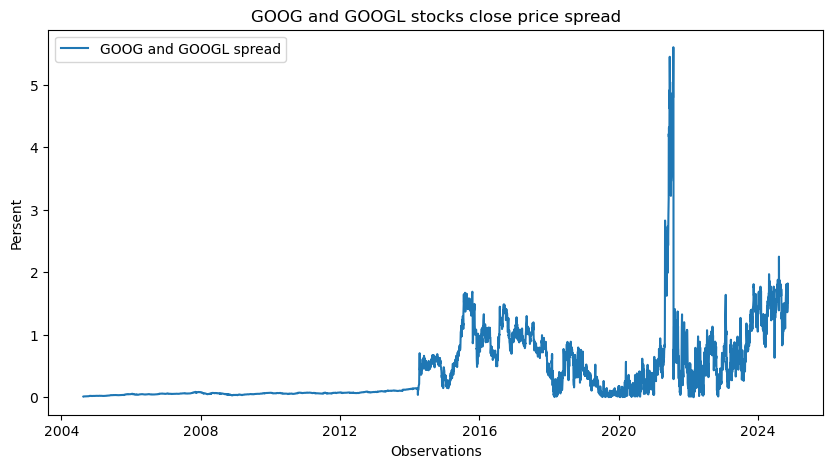

In [123]:
figure, ax = plt.subplots(figsize=(10,5))
ax.plot(spread.index, spread.values, label='GOOG and GOOGL spread')
plt.title('GOOG and GOOGL stocks close price spread')
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

In [124]:
sample = spread.values
sample_dates = spread.index

In [125]:
MODEL = 'CEV'

euler_CEV, shoji_Ozaki_CEV, kessler_CEV = (ModelEstimator(sample, model_name="CEV", models=CEV()),
                                            ModelEstimator(sample, model_name="CEV", models=CEV()),
                                            ModelEstimator(sample, model_name="CEV", models=CEV())
)
params_euler = (euler_CEV.fit_euler())[1]
params_shoji = (shoji_Ozaki_CEV.fit_shoji_ozaki())[1]
params_kessler = (kessler_CEV.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.11988837025


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 360, CG iterations: 253, optimality: 1.35e-05, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [4.29050717 0.48913548 2.32119806 0.46109799]
Final Likelihood: 6366.860183079327
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.11988837025
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 360, CG iterations: 253, optimality: 1.35e-05, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [4.29050717 0.48913548 2.32119806 0.46109799]
Final Likelihood: 6366.860183079327
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.60746168948
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 305, CG iterations: 193, optimality: 1.98e+00, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [1.38114676 1.36001875 2.32578301 0.46006504]
Final 

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1123020714.py:11: RuntimeWarning: invalid value encountered in scalar power
  dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW


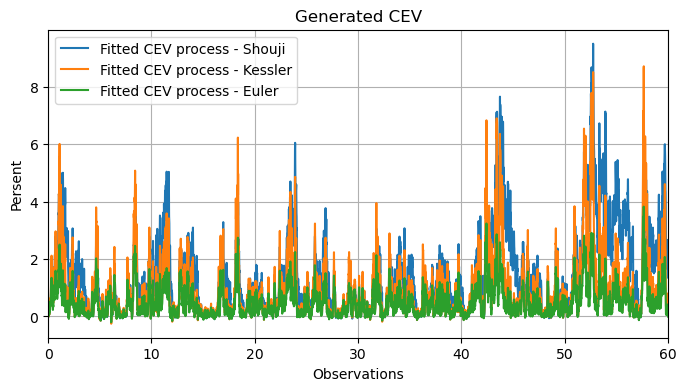

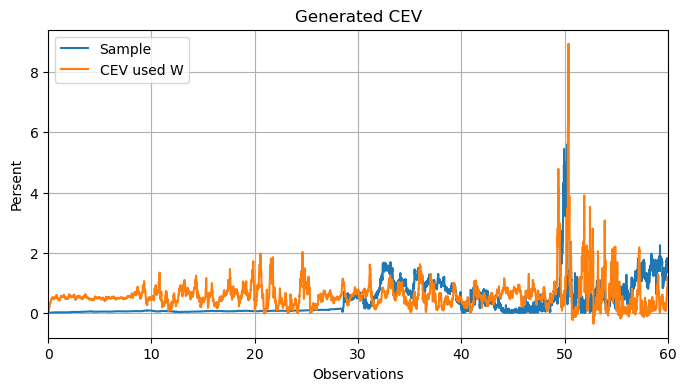

In [126]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = params_kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = np.nan_to_num(cev_s[i-1] + processes[MODEL](cev_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW), cev_s[i-1])
    cev_k[i] = np.nan_to_num(cev_k[i-1] + processes[MODEL](cev_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], params_kessler_p[3], dt, dW), cev_k[i-1])
    cev_e[i] = np.nan_to_num(cev_e[i-1] + processes[MODEL](cev_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW), cev_e[i-1])
    ecev[i] = np.nan_to_num(ecev[i-1] + processes[MODEL](ecev[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1]), ecev[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, cev_s , label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, cev_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, cev_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [127]:
MODEL = 'CKLS'

euler_CKLS, shoji_Ozaki_CKLS, kessler_CKLS = (ModelEstimator(sample, model_name="CKLS", models=CKLS()),
                                            ModelEstimator(sample, model_name="CKLS", models=CKLS()),
                                            ModelEstimator(sample, model_name="CKLS", models=CKLS())
)
params_euler = (euler_CKLS.fit_euler())[1]
params_shoji = (shoji_Ozaki_CKLS.fit_shoji_ozaki())[1]
params_kessler = (kessler_CKLS.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169802.07638781887


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 345, CG iterations: 193, optimality: 3.56e-05, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [1.7138346  0.01000601 2.32082856 0.45971191]
Final Likelihood: 6355.402792192872
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169802.07638781887
`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 345, CG iterations: 193, optimality: 3.56e-05, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [1.7138346  0.01000601 2.32082856 0.45971191]
Final Likelihood: 6355.402792192872
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169801.5894450969
`xtol` termination condition is satisfied.
Number of iterations: 159, function evaluations: 730, CG iterations: 565, optimality: 2.33e+00, constraint violation: 0.00e+00, execution time: 0.72 s.
Final Params: [1.61913549 1.07278529 2.31903567 0.45976952]
Final 

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\1826396453.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 + theta2 * dx) * dt + theta3 * pow(dx, theta4) * dw


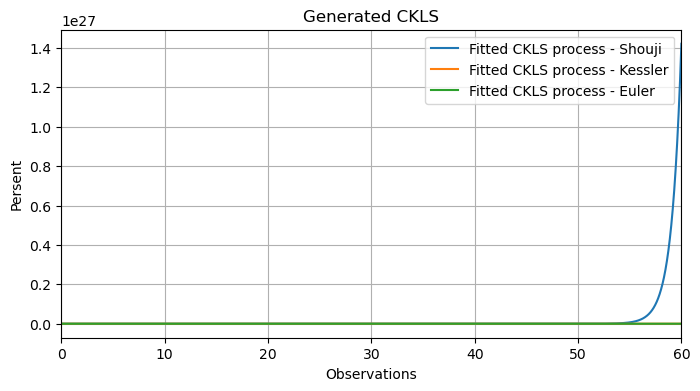

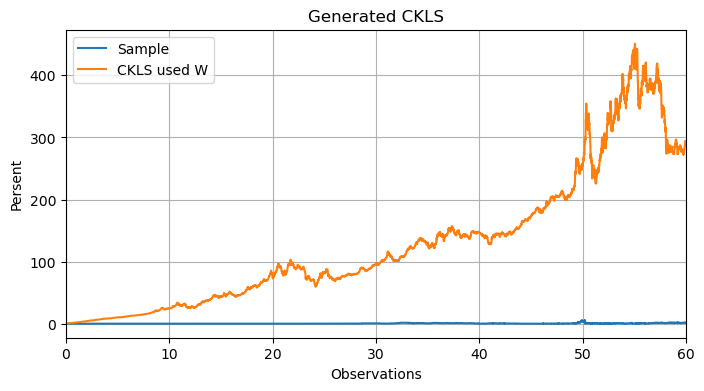

In [128]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = params_kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = np.nan_to_num(ckls_s[i-1] + processes[MODEL](ckls_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], params_shoji_p[3], dt, dW), ckls_s[i-1])
    ckls_k[i] = np.nan_to_num(ckls_k[i-1] + processes[MODEL](ckls_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], params_kessler_p[3], dt, dW), ckls_k[i-1])
    ckls_e[i] = np.nan_to_num(ckls_e[i-1] + processes[MODEL](ckls_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, dW), ckls_e[i-1])
    eckls[i] = np.nan_to_num(eckls[i-1] + processes[MODEL](eckls[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], params_euler_p[3], dt, cW[i-1]), eckls[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, ckls_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ckls_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ckls_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [129]:
MODEL = 'OU'

euler_OrnsteinUhlenbeck, shoji_Ozaki_OrnsteinUhlenbeck, kessler_OrnsteinUhlenbeck = (ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck()),
                                            ModelEstimator(sample, model_name="OrnsteinUhlenbeck", models=OrnsteinUhlenbeck())
)
params_euler = (euler_OrnsteinUhlenbeck.fit_euler())[1]
params_shoji = (shoji_Ozaki_OrnsteinUhlenbeck.fit_shoji_ozaki())[1]
params_kessler = (kessler_OrnsteinUhlenbeck.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47055.13536535908
`xtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 204, CG iterations: 111, optimality: 1.95e-05, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [2.4455981  0.53776666 1.617357  ]
Final Likelihood: 4333.684169983042
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47055.13536535908
`xtol` termination condition is satisfied.
Number of iterations: 50, function evaluations: 204, CG iterations: 111, optimality: 1.95e-05, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [2.4455981  0.53776666 1.617357  ]
Final Likelihood: 4333.684169983042
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -47056.31052953926
`xtol` termination condition is satisfied.
Number of iterations: 145, function evaluations: 640, CG iterations: 362, optimality: 6.24e-01, constraint violation: 0.00e+00, execution time: 0.51 s.
Final Params: [1.74695998 0.

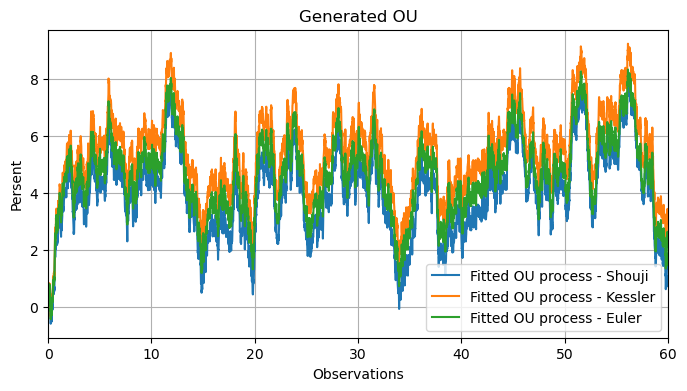

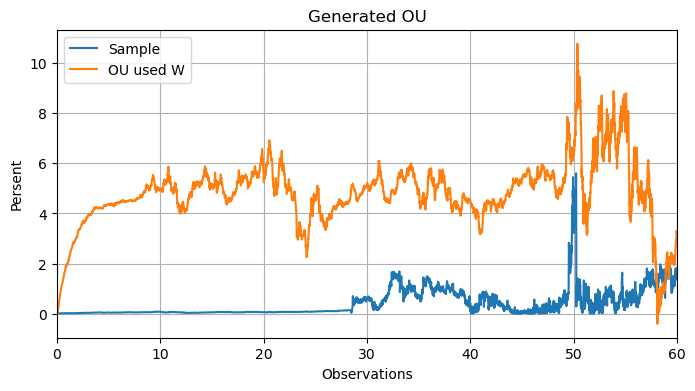

In [130]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [131]:
MODEL = 'CIR'

euler_CIR, shoji_Ozaki_CIR, kessler_CIR = (ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR()),
                                            ModelEstimator(sample, model_name="CIR", models=CIR())
)
params_euler = (euler_CIR.fit_euler())[1]
params_shoji = (shoji_Ozaki_CIR.fit_shoji_ozaki())[1]
params_kessler = (kessler_CIR.fit_kessler())[1]


params_euler_p = params_euler[0].tolist()
params_shoji_p = params_shoji[0].tolist()
params_kessler_p = params_kessler[0].tolist()

Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66989.98247236079
`gtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 240, CG iterations: 107, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [3.85429642 0.45267223 1.99999999]
Final Likelihood: 6188.423424761842
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66989.98247236079


c:\miniconda3\Lib\site-packages\scipy\optimize\_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 240, CG iterations: 107, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [3.85429642 0.45267223 1.99999999]
Final Likelihood: 6188.423424761842
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.2297525083
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 204, CG iterations: 76, optimality: 7.29e-01, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [1.23085898 1.25620997 1.99997201]
Final Likelihood: 6178.340981205236
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.2297525083
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 204, CG iterations: 76, optimality: 7.29e-01, constraint violation: 0.00e+00, execution time: 0.13 s.
Final Params: [1.23085898 1.25620997 1.99997201]
Final Likelihood: 6178.340981205236
Initial Params: [0.01

C:\Users\Астемир\AppData\Local\Temp\ipykernel_5280\4114572489.py:2: RuntimeWarning: invalid value encountered in scalar power
  return (theta1 - theta2 * dx) * dt + theta3 * dx ** 0.5 * dw


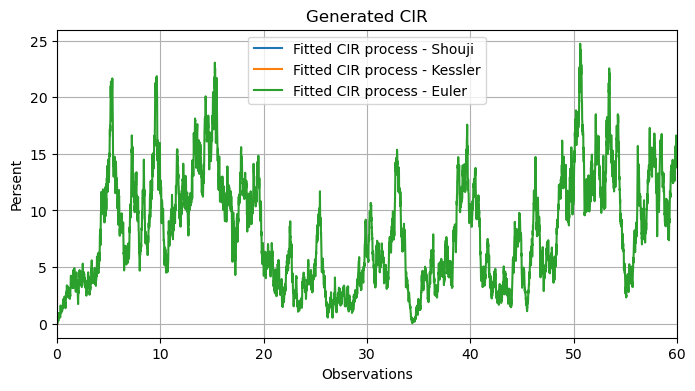

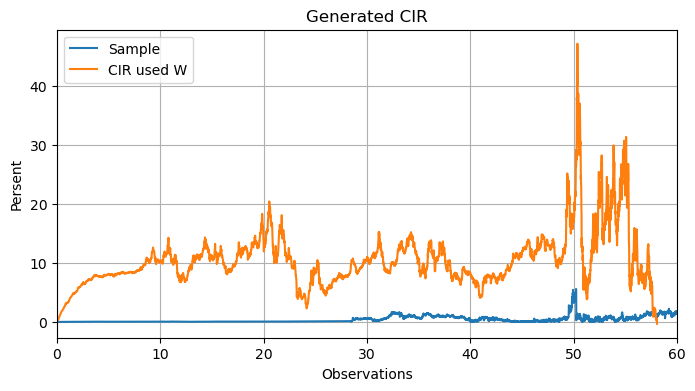

In [132]:
# Set data and generate the process:
T = 60
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma = params_kessler_p
gamma = 0.0
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ou_s, ou_k, ou_e = np.zeros(N), np.zeros(N), np.zeros(N)
ou_s[0], ou_k[0], ou_e[0] = S0, S0, S0
eou = np.zeros(N)
eou[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ou_s[i] = ou_s[i-1] + processes[MODEL](ou_s[i-1], params_shoji_p[0], params_shoji_p[1], params_shoji_p[2], gamma, dt, dW)
    ou_k[i] = ou_k[i-1] + processes[MODEL](ou_k[i-1], params_kessler_p[0], params_kessler_p[1], params_kessler_p[2], gamma, dt, dW)
    ou_e[i] = ou_e[i-1] + processes[MODEL](ou_e[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, dW)
    eou[i] = eou[i-1] + processes[MODEL](eou[i-1], params_euler_p[0], params_euler_p[1], params_euler_p[2], gamma, dt, cW[i-1])

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, ou_s, label=f"Fitted {MODEL} process - Shouji")
plt.plot(time_line, ou_k, label=f"Fitted {MODEL} process - Kessler")
plt.plot(time_line, ou_e, label=f"Fitted {MODEL} process - Euler")
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(8, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eou, label=f'{MODEL} used W')
plt.title(f"Generated {MODEL}")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

In [133]:
# a) fit using Euler method:

# Choose several models:
model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

#pb = param_bounds[0]
#pg = np.array([1., 0.5])
#m = BrownianMotion()

# Set parameters for estimators:
dt = 1. / 252
K = 1
eu_params = []
oz_params = []
so_params = []
ks_params = []
ex_params = []

#euler_est = AnalyticalMLE(sample, param_bounds[0], dt, density=EulerDensity(model[0])).estimate_params(param_guess[0])

for k in tqdm(range(K)):
    seed = rnd.randint(1, 10000)
    euler_est_bic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    euler_est_aic   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    euler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    ozaki_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    ozaki_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    ozaki_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=OzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    shoji_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    shoji_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    shoji_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    kessler_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    kessler_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    kessler_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]
    exact_est_bic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).bic \
                 for i in range (len(param_bounds))]
    exact_est_aic = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
                 for i in range (len(param_bounds))]
    exact_params = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
                 for i in range (len(param_bounds))]

  0%|          | 0/1 [00:00<?, ?it/s]

Initial Params: [0.01, 0.2]
Initial Likelihood: -47055.403279490485
`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 78, CG iterations: 46, optimality: 3.34e-07, constraint violation: 0.00e+00, execution time: 0.092 s.
Final Params: [0.30179984 1.61972959]
Final Likelihood: 4326.222872351848
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.11988837025
`xtol` termination condition is satisfied.
Number of iterations: 77, function evaluations: 360, CG iterations: 253, optimality: 1.35e-05, constraint violation: 0.00e+00, execution time: 0.27 s.
Final Params: [4.29050717 0.48913548 2.32119806 0.46109799]
Final Likelihood: 6366.860183079327
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66989.98247236079
`gtol` termination condition is satisfied.
Number of iterations: 63, function evaluations: 240, CG iterations: 107, optimality: 4.51e-07, constraint violation: 0.00e+00, execution time:  0.2 s.
Final Params: [3.85429642 0.

c:\miniconda3\Lib\site-packages\pymle\core\TransitionDensity.py:114: RuntimeWarning: invalid value encountered in divide
  temp = mu * (np.exp(mu_x * dt) - 1) / mu_x


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 6, CG iterations: 498, optimality: nan, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01 0.2 ]
Final Likelihood: nan
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -169815.542465714
`xtol` termination condition is satisfied.
Number of iterations: 115, function evaluations: 550, CG iterations: 367, optimality: 5.81e-05, constraint violation: 0.00e+00, execution time: 0.48 s.
Final Params: [6.91521506 0.37316772 2.65188074 0.58470656]
Final Likelihood: 6558.219338124541
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -66991.17559956505
`xtol` termination condition is satisfied.
Number of iterations: 57, function evaluations: 192, CG iterations: 111, optimality: 6.05e-05, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [3.54696709 0.60215122 1.99999995]
Final Likelihood: 6429.6225761490305
Initial Params: [0.01, 0.2]
I

100%|██████████| 1/1 [00:28<00:00, 28.25s/it]

`xtol` termination condition is satisfied.
Number of iterations: 66, function evaluations: 345, CG iterations: 193, optimality: 3.56e-05, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [1.7138346  0.01000601 2.32082856 0.45971191]
Final Likelihood: 6355.402792192872


In [134]:
get_results(models, euler_est_aic, euler_params)
print()
print('=========================================================================================')
print()
get_results(models, euler_est_bic, euler_params)

AIC values for Shoji-Ozaki estimation:
         -8648.446 - BM model with params [0.30179984 1.61972959],
         -12725.720 - CEV model with params [4.29050717 0.48913548 2.32119806 0.46109799],
         -12370.847 - CIR model with params [3.85429642 0.45267223 1.99999999],
         -1666.333 - GBM model with params [0.97872002 2.        ],
         -1683.800 - IGBM model with params [0.89185165 0.209187   1.99999999],
         -8661.368 - OU model with params [2.4455981  0.53776666 1.617357  ],
         -12702.806 - CKLS model with params [1.7138346  0.01000601 2.32082856 0.45971191],
         
The best model is CEV         with param [4.29050717 0.48913548 2.32119806 0.46109799]


AIC values for Shoji-Ozaki estimation:
         -8635.375 - BM model with params [0.30179984 1.61972959],
         -12699.579 - CEV model with params [4.29050717 0.48913548 2.32119806 0.46109799],
         -12351.241 - CIR model with params [3.85429642 0.45267223 1.99999999],
         -1653.262 - GBM mode

1

In [135]:

get_results(models, shoji_est_aic, shoji_ozaki_params)
print()
print('=========================================================================================')
print()
get_results(models, shoji_est_bic, shoji_ozaki_params)


AIC values for Shoji-Ozaki estimation:
         -8648.446 - BM model with params [0.01055339 1.04212238],
         -12715.163 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -12350.682 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -1798.435 - GBM model with params [0.0341869  0.24484606],
         -1680.226 - IGBM model with params [0.14231153 5.1889788  0.24476733],
         -8659.697 - OU model with params [0.01274842 0.40623348 1.04213606],
         -12690.059 - CKLS model with params [0.03828952 0.01002051 0.59006865 0.31925333],
         
The best model is CEV         with param [0.0113267  0.22271155 0.59021228 0.31912468]


AIC values for Shoji-Ozaki estimation:
         -8635.375 - BM model with params [0.01055339 1.04212238],
         -12689.022 - CEV model with params [0.0113267  0.22271155 0.59021228 0.31912468],
         -12331.076 - CIR model with params [0.0250517  2.42993256 0.44609072],
         -1785.365 - GBM mode

1

In [136]:
get_results(models, kessler_est_aic, kessler_params)
print()
print('=========================================================================================')
print()
get_results(models, kessler_est_bic, kessler_params)

AIC values for Shoji-Ozaki estimation:
         -8648.446 - BM model with params [0.30230542 1.6197302 ],
         -12761.297 - CEV model with params [2.97086638 0.95222324 3.1163384  0.61739443],
         -12242.630 - CIR model with params [0.30479617 1.94012275 1.99997171],
         -1911.284 - GBM model with params [5.0288319  1.99999996],
         -2007.571 - IGBM model with params [3.60298209 0.18857678 1.99999999],
         -8662.474 - OU model with params [2.76300258 0.51386111 1.61693441],
         -12843.576 - CKLS model with params [2.48008602 0.83448938 2.66776743 0.56871296],
         
The best model is CKLS         with param [2.48008602 0.83448938 2.66776743 0.56871296]


AIC values for Shoji-Ozaki estimation:
         -8635.375 - BM model with params [0.30230542 1.6197302 ],
         -12735.157 - CEV model with params [2.97086638 0.95222324 3.1163384  0.61739443],
         -12223.025 - CIR model with params [0.30479617 1.94012275 1.99997171],
         -1898.213 - GBM mod

6